In [1]:
import os
import math
import pandas as pd
import datetime as dt
import matplotlib.pylab as plt
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
from pandas.api.types import CategoricalDtype
from dateutil.relativedelta import relativedelta
from IPython.display import display


BASE_DIR = os.getcwd()
DATA_FP = os.path.join(BASE_DIR, 'loan.csv')

EARLIEST_ISSUE = dt.date(2007,6,1)
LAST_PAYMENT_DATE = dt.date(2016,1,1)
pd.options.display.max_columns = 999



In [2]:
raw_data = pd.read_csv(DATA_FP, low_memory=False)

emp_title
51462


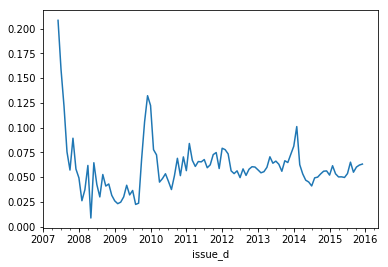

emp_length
44825


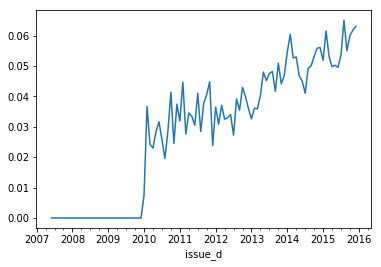

annual_inc
4


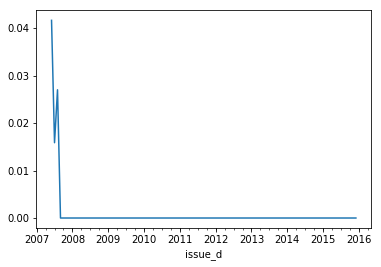

desc
761351


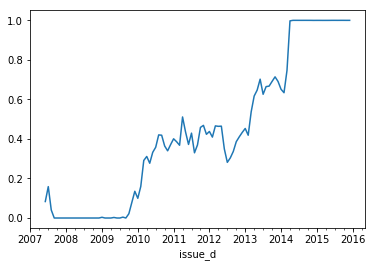

title
152


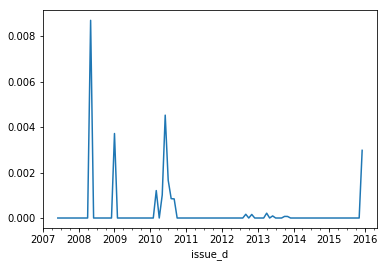

delinq_2yrs
29


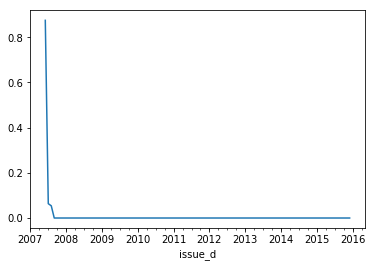

earliest_cr_line
29


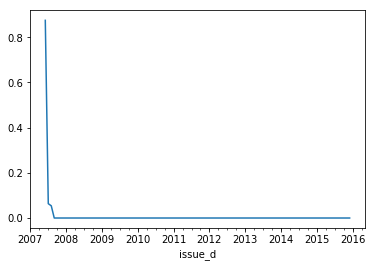

inq_last_6mths
29


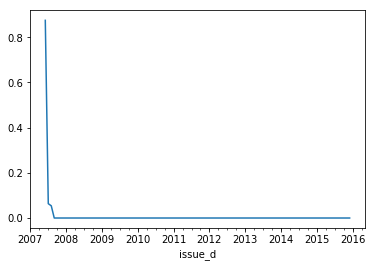

mths_since_last_delinq
454312


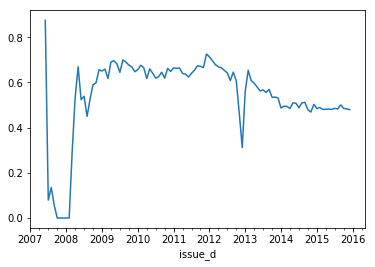

mths_since_last_record
750326


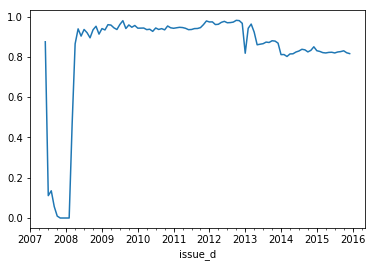

open_acc
29


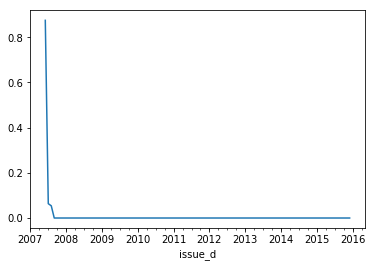

pub_rec
29


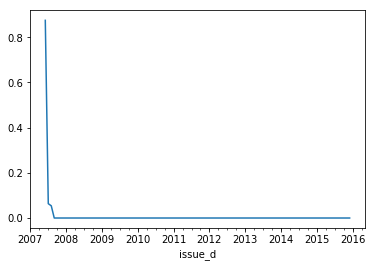

revol_util
502


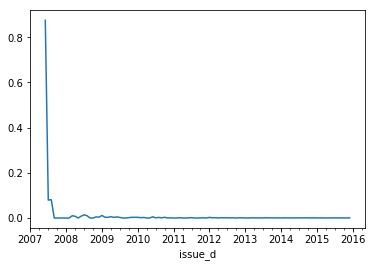

total_acc
29


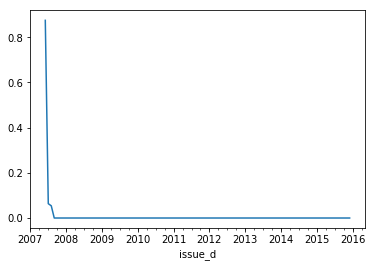

last_pymnt_d
17659


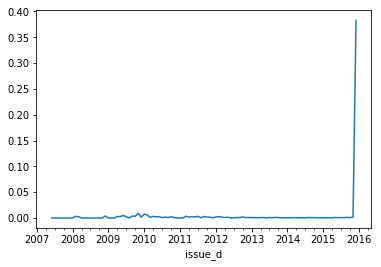

next_pymnt_d
252971


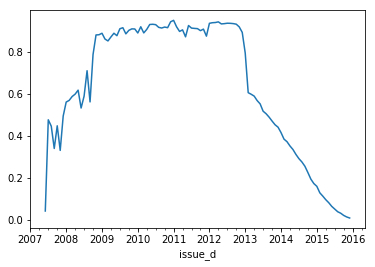

last_credit_pull_d
53


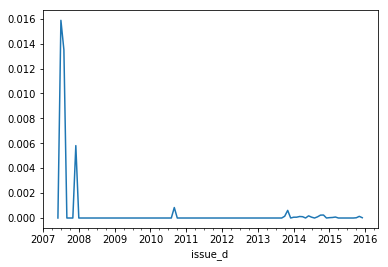

collections_12_mths_ex_med
145


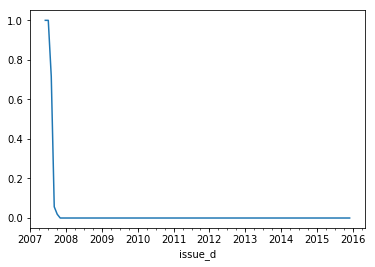

mths_since_last_major_derog
665676


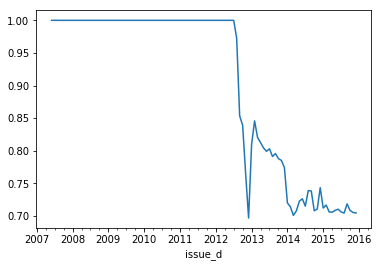

annual_inc_joint
886868


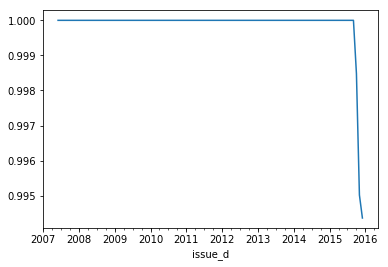

dti_joint
886870


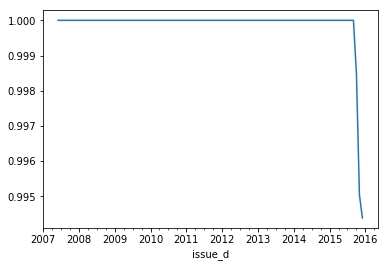

verification_status_joint
886868


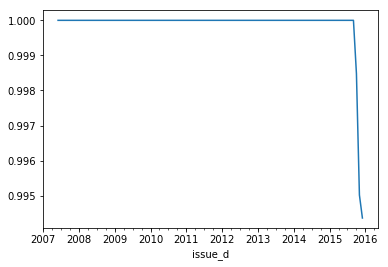

acc_now_delinq
29


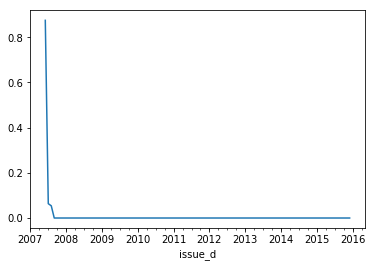

tot_coll_amt
70276


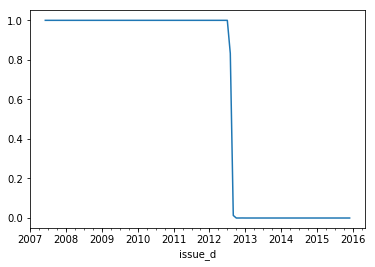

tot_cur_bal
70276


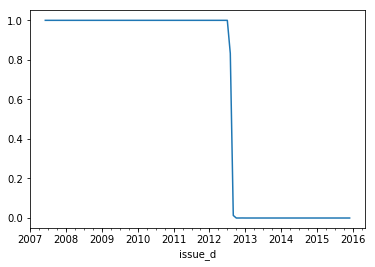

open_acc_6m
866007


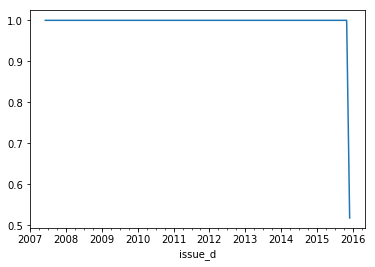

open_il_6m
866007


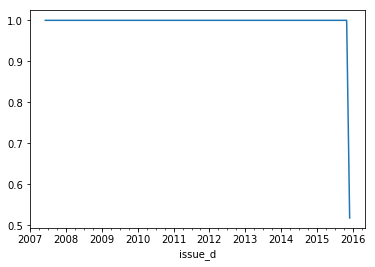

open_il_12m
866007


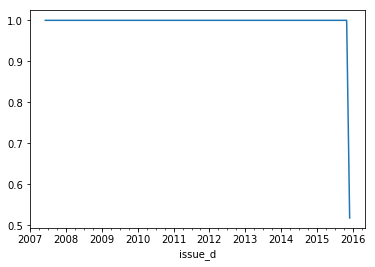

open_il_24m
866007


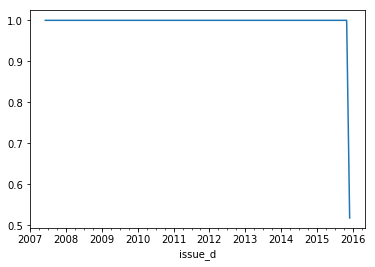

mths_since_rcnt_il
866569


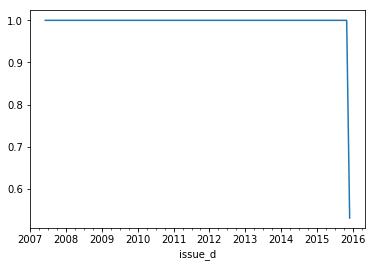

total_bal_il
866007


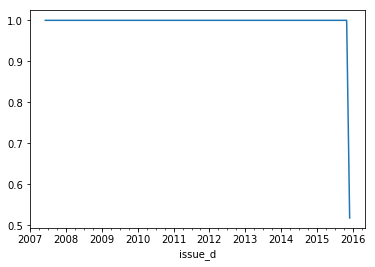

il_util
868762


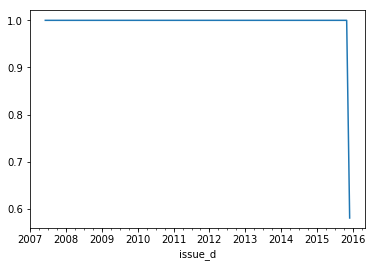

open_rv_12m
866007


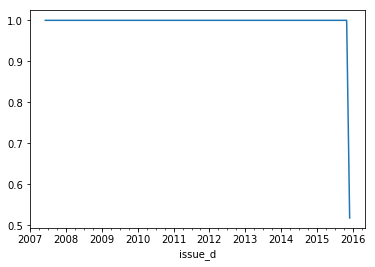

open_rv_24m
866007


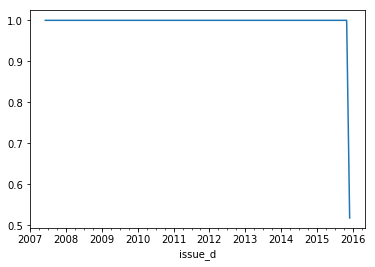

max_bal_bc
866007


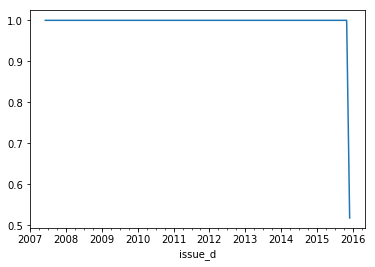

all_util
866007


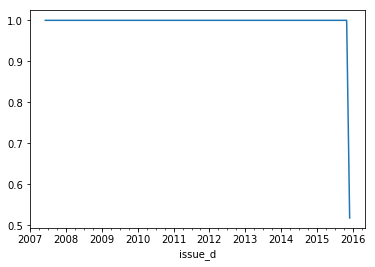

total_rev_hi_lim
70276


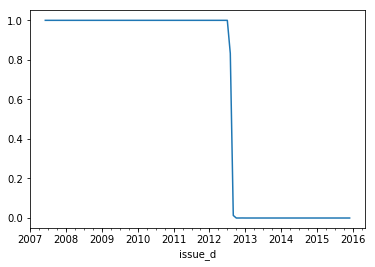

inq_fi
866007


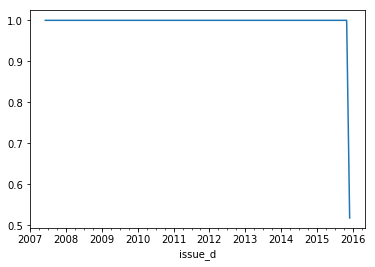

total_cu_tl
866007


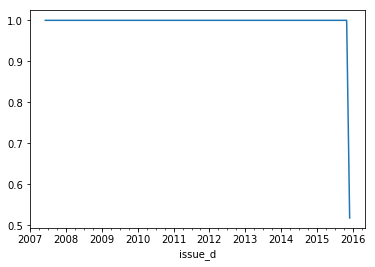

inq_last_12m
866007


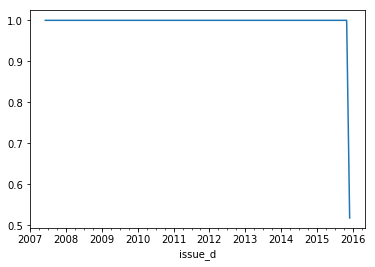

In [3]:
def NaN_over_time(df):
    '''
    for columns with missing values its useful to examine how they are distributed
    with respect to time.  Here we plot, percentage of records with null values over issue date.
    '''
    df.issue_d = pd.to_datetime(df.issue_d, format="%b-%Y")
    df = df.set_index(df.issue_d)
    for column in df.columns:
        s = df[column]
        if(s.isnull().sum() > 0):
            print(column)
            print(s.isnull().sum())
            s.groupby(s.index).apply(lambda x: 1 if x.size == 0 else x.isnull().sum() / x.size).plot()
            plt.show()


NaN_over_time(raw_data)

In [4]:
def cull_data(df):
    
    # drop id and member_id columns - each is unique in this dataset
    df = df.drop(['id', 'member_id'], axis=1)
    
    # potentially useful and interesting data, but NLP outof scope for initial modeling
    df = df.drop(['emp_title', 'title', 'desc', 'url'], axis =1)
    
    # drop 4 records with no annual income information
    df = df[~(df.annual_inc.isnull())]

    # there are 29 early loans that lack a lot of information drop these rows
    df = df[~(df.delinq_2yrs.isnull())]
    df = df[~(df.earliest_cr_line.isnull())]
    df = df[~(df.inq_last_6mths.isnull())]
    df = df[~(df.open_acc.isnull())]
    df = df[~(df.pub_rec.isnull())]
    df = df[~(df.total_acc.isnull())]
        
    # drop 'mths_since_last_record' and 'mths_since_last_major_derog'.  
    # These columns are null for ~85% of records and are distributed strangly
    # w.r.t time.  indicating, lending club changed their data collection practices
    df = df.drop(['mths_since_last_record', 'mths_since_last_major_derog'], axis=1)
    
    # looking at the distributions of missing values w.r.t time shows that lending club
    # added many new data-elements in 2013 and 2015, these are unsuitable for modeling.
    df = df.drop(['annual_inc_joint', 'dti_joint', 'verification_status_joint',
                  'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 
                 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
                 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
                  'inq_last_12m'
                 ], axis=1)
    
    # these columns are binary-valued with over 99.9% of records taking the more common value.
    df = df[df.pymnt_plan =="n"] # drop 10 rows
    df = df[df.application_type =="INDIVIDUAL"] #drop 511 "JOINT" rows
    
    df = df.drop(['pymnt_plan', 'application_type', 'policy_code'], axis=1)
    return df

print (raw_data.shape)
data = cull_data(raw_data)
print (data.shape)

(887379, 74)
(886829, 43)


In [5]:
def transform(df):
    
    #convert term to int: duration in months
    df.term = df.term.apply(lambda x : int(x.split(" ")[1]))

    # add column flagging were employement length was imputed
    df['emp_length_imp'] = df.emp_length.isnull().astype('int')
    
    # convert employemnt length to numeric and imputer missing values with median
    df.emp_length = df.emp_length.replace("< 1 year", "0")
    df.emp_length = df.emp_length.str.extract('(\d+)', expand=False)
    df.emp_length = df.emp_length.fillna(df.emp_length.median()).astype('int')
    
    # Bin the mths_since_last_delinq field as there's no good way to
    # impute NaN values
    df['mths_since_last_delinq_0_24'] = (df.mths_since_last_delinq <= 24).astype(int)
    
    df['mths_since_last_delinq_24_48'] = (
        (df.mths_since_last_delinq > 24) & 
        (df.mths_since_last_delinq <= 48)
    ).astype(int)
    
    df['mths_since_last_delinq_48_72'] = (
        (df.mths_since_last_delinq > 48) & 
        (df.mths_since_last_delinq <= 72)
    ).astype(int)
    
    df['mths_since_last_delinq_72_96'] = (
        (df.mths_since_last_delinq > 72) & 
        (df.mths_since_last_delinq <= 96)
    ).astype(int)
    
    df['mths_since_last_delinq_96_inf'] = (
        (df.mths_since_last_delinq > 96) 
    ).astype(int)
    
    df = df.drop('mths_since_last_delinq', axis=1)
    
    df.revol_util = df.revol_util.fillna(df.revol_util.median())
    df.collections_12_mths_ex_med = df.collections_12_mths_ex_med.fillna(df.collections_12_mths_ex_med.mode()[0])

    #convert to categorical
    grade_cats = CategoricalDtype(categories=['G', 'F', 'E', 'D', 'C', 'B',
                                              'A'], ordered=True) 
    df.grade = df.grade.astype(grade_cats)
    sub_grade_cats = CategoricalDtype(categories=[
        'G5', 'G4', 'G3', 'G2', 'G1',
        'F5', 'F4', 'F3', 'F2', 'F1',
        'E5', 'E4', 'E3', 'E2', 'E1',
        'D5', 'D4', 'D3', 'D2', 'D1',
        'C5', 'C4', 'C3', 'C2', 'C1',
        'B5', 'B4', 'B3', 'B2', 'B1',
        'A5', 'A4', 'A3', 'A2', 'A1',
    ], ordered=True)
    df.sub_grade = df.sub_grade.astype(sub_grade_cats)
    
    categorical_cols = [
        'home_ownership', 'verification_status', 'loan_status', 'purpose', 
        'zip_code', 'addr_state', 'initial_list_status'
    ]
    for col in categorical_cols:
        df[col] = df[col].astype("category")

    
    #convert to datetimes
    datetime_cols = [
        'issue_d', 'earliest_cr_line', 'last_pymnt_d',
        'next_pymnt_d', 'last_credit_pull_d'
    ]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], format="%b-%Y")
    df.issue_d = pd.to_datetime(df.issue_d, format="%b-%Y")
    df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format="%b-%Y")
    df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d, format="%b-%Y")
    
    #NaTs in last payment date indicate borrower didn't make a single payment
    df.last_pymnt_d = df.last_pymnt_d.fillna(df.issue_d)

    #NaNs in next payment date column most likely indicate loan has been closed
    df.next_pymnt_d = df.next_pymnt_d.fillna(df.last_pymnt_d)
    
    
    
    # drop 27368 records that were issued on or after 2015-12-1.  Observed issues where
    # lending club's data conflicted - i.e. the "total payment" field wouldn't account for
    # payments they were shown to have made on 2016-1-1.
    df = df[~(df.issue_d >= dt.date(2015,12,1))]
    
    return(df)
    

cleaned_data = transform(data)


In [6]:
def get_loan_duration(df):
    '''
    Best attempt to determine how long a given loan was (is) open.  This is NOT the loan-term.  ASSUMPTION - it takes 
    a loan 180 days from the start of non-payment to charge-off.  There are three cases
    that must be handled differently:
    
        1) loan is closed and fully paid
        2) loan is closed and charged off
        3) loan is open
    
    '''
    
    df['loan_duration'] = np.nan

    #case 1
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Fully Paid", 
             "Does not meet the credit policy. Status:Fully Paid"
            ]
        )), "loan_duration"
    ] = round((df.last_pymnt_d - df.issue_d) / np.timedelta64(1,"M")) / 12
    
    df.loc[df.loan_duration == 0, "loan_duration"] = 1/12

    #case 2 - 150 days until it enters collection
    df.loc[
        (~df.loan_is_open) & 
        (df.loan_status.isin(
            ["Charged Off", 
             "Does not meet the credit policy. Status:Charged Off"
            ])), "loan_duration"
    ] = (
        ((df.last_pymnt_d - df.issue_d) + np.timedelta64(150,"D")) / np.timedelta64(1,"Y")
    )
    
    #case 3
    df.loc[
        df.loan_is_open, 
        'loan_duration'
    ] = (LAST_PAYMENT_DATE - df.issue_d) / np.timedelta64(1,"Y")

    return(df)


def get_performance_features(df):
    
    # represents percentage return of loan
    s = (df.total_pymnt - df.funded_amnt) / df.funded_amnt
    
    # raw ROI normalizes return over duration of loan
    df['raw_ROI'] = s / df.loan_duration
    
    # tern ROI normalizes return over term of loans 
    df['term_ROI'] = s/(df.term / 12)
    
    return df

    
def add_features(df):
    
    
    df['loan_is_open'] = df.loan_status.isin([
        'Current', 'Late (31-120 days)', 'Issued', 
        'In Grace Period', 'Late (16-30 days)', 'Default'
    ])
    
    df['maturity_d'] = pd.NaT
    df.loc[df.term == 36, 'maturity_d'] = df.issue_d + pd.offsets.DateOffset(years=3)
    df.loc[df.term == 60, 'maturity_d'] = df.issue_d + pd.offsets.DateOffset(years=5)
    
    df['earliest_cr_delta'] = (df.issue_d - df.earliest_cr_line).dt.days
    
    # total revoling credit limit
    df['revol_limit'] = df.revol_bal
    df.loc[df.revol_util != 0, "revol_limit"] = df.revol_bal / (df.revol_util / 100) 
    
    df['avg_revol_acc_limit'] = df.revol_limit
    df.loc[df.open_acc != 0, 'avg_revol_acc_limit'] = df.revol_limit / df.open_acc
    
    df['avg_revol_acc_bal'] = df.revol_bal
    df.loc[df.open_acc != 0, 'avg_revol_acc_bal'] = df.revol_bal / df.open_acc
    
    df['percentage_funded'] = df.funded_amnt_inv / df.loan_amnt
    
    df['inst_to_income'] = 1
    df.loc[df.annual_inc != 0, 'inst_to_income'] = df.installment / df.annual_inc
    
    return df

def enrich_data(df):
    return (df.pipe(add_features).pipe(get_loan_duration).pipe(get_performance_features))
    
enriched_data = enrich_data(cleaned_data)

            

In [7]:
enriched_data.describe(include='all')

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,emp_length_imp,mths_since_last_delinq_0_24,mths_since_last_delinq_24_48,mths_since_last_delinq_48_72,mths_since_last_delinq_72_96,mths_since_last_delinq_96_inf,loan_is_open,maturity_d,earliest_cr_delta,revol_limit,avg_revol_acc_limit,avg_revol_acc_bal,percentage_funded,inst_to_income,loan_duration,raw_ROI,term_ROI
count,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737,842737,842737.000000,842737,8.427370e+05,842737,842737,842737,842737,842737,842737,842737.000000,842737.000000,842737,842737.000000,842737.000000,842737.000000,8.427370e+05,842737.000000,842737.000000,842737,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737,842737.000000,842737,842686,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737,842737,842737.000000,8.427370e+05,8.427370e+05,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000,842737.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,7,35,NaN,6,NaN,3,102,9,14,932,51,NaN,NaN,694,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,NaN,100,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,B,B3,NaN,MORTGAGE,NaN,Source Verified,2015-10-01 00:00:00,Current,debt_consolidation,945xx,CA,NaN,NaN,2001-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,2016-02-01 00:00:00,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2018-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,241109,53440,NaN,421745,NaN,311815,48557,566247,498980,9298,123478,NaN,NaN,6346,NaN,NaN,NaN,NaN,NaN,NaN,448335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442917,NaN,516757,686480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,587416,37298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1944-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-01 00:00:00,NaN,2007-12-01 00:00:00,2007-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,2016-03-01 00:00:00,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,14738.147874,14724.054272,14683.081955,43.179606,13.296999,436.746738,NaN,NaN,6.012603,NaN,7.480535e+04,NaN,NaN,NaN,NaN,NaN,NaN,18.064291,0.312746,NaN,0.699314,11.523563,0.192563,1.688521e+04,55.217251,25.264206,NaN,8066.118177,8062.940288,7938.059214,7898.528691,6046.289033,1843.007927,0.417431,48.344825,5.136907,NaN,2257.351414,NaN,NaN,0.013902,0.004958,0.049834,0.195870,0.162331,0.098296,0.029585,0.000244,NaN,NaN,5959.121518,3.731447e+04,3.396324e+03,1561.454931,0.995670,0.006659,1.186655,-0.968748,-0.122846
std,8418.981962,8413.086190,8426.042476,10.989265,4.384879,243.905497,NaN,NaN,3.569197,NaN,6.243553e+04,NaN,NaN,NaN,NaN,NaN,NaN,8.271677,0.859514,NaN,1.003509,5.294738,0.576673,2.237342e+04,23.799544,11.824779,NaN,8346.757705,8343.538285,7888.048991,7863.484546,6664.354506,2113.506918,4.191322,420.231089,64.737816,NaN,4886.860224,NaN,NaN,0.132266,0.0

In [8]:
def get_ROIs_per_month(df):

    def make_payment_history(df, term):
        '''
        construct payment histories for each loan.  
        '''
        
        # for borrowers that paid off their loans early, assume they do it in equal allotments
        df['modified_installment'] = df.installment
        df.loc[df.loan_status.isin([
            "Fully Paid", 
            "Does not meet the credit policy. Status:Fully Paid"
        ]) & (round((df.last_pymnt_d - df.issue_d) / np.timedelta64(1,"M")) < term),
               "modified_installment"] = df.total_pymnt / (round(
                    (df.last_pymnt_d - df.issue_d) / 
                    np.timedelta64(1, "M")
                ))
    
        for period in range(1, term+1):
            pymnt_name = str(period)+"_month_pymnt"
            ROI_name = str(period) +"_month_ROI"
            df[pymnt_name] = np.NaN
            df[ROI_name] = np.NaN
            
            statement_date = (df.issue_d + pd.DateOffset(months = period))
            
            months_since_last_pymnt = round(
                (statement_date - df.last_pymnt_d) / np.timedelta64(1, 'M')
            ).astype(int)
            
                
            
            #case 1, statement is on or before last payment date.  Assume full payment was made
            df.loc[months_since_last_pymnt <= 0, pymnt_name] = df.modified_installment
            
            #case 2, statement is after last payment date.  Assume 0 payment
            df.loc[months_since_last_pymnt > 0, pymnt_name] = 0
            
            #case 3, statement is 5 months after payment date.  
            #Assume payment equals net recoveries (if there are any)
            df.loc[
                (months_since_last_pymnt == 5), pymnt_name
            ] = df.recoveries - df.collection_recovery_fee
            
            #case 4, statement is beyond last date of data set.  Future payments unknown, fill with NaN's
            df.loc[statement_date > LAST_PAYMENT_DATE, pymnt_name] = np.NaN
            
            
            #case 1, statement is before or on last payment date.
            #payment_to_date = installment*period
            df.loc[months_since_last_pymnt <= 0, ROI_name] = (
                (((df.modified_installment*period) - df.funded_amnt) / df.funded_amnt)
            )
            
            #case 2, statement is after last payment date, but before collections
            #payment_to_date = installment*(last_payment_d - issue_d)
            df.loc[ 
                (months_since_last_pymnt > 0) &
                (months_since_last_pymnt < 5),
                ROI_name
            ] = (
                    (df.modified_installment*round((df.last_pymnt_d - df.issue_d) 
                                       / np.timedelta64(1,"M")) - df.funded_amnt
                    ) / df.funded_amnt 
                )
            
            #case 3, statement is after collections.
            #Total payment = df.total_pymnt
            df.loc[
                (months_since_last_pymnt >= 5), ROI_name
            ] = (
                ((df.total_pymnt - df.funded_amnt) / df.funded_amnt)
            )
                        
        return df

    df_3years = df.loc[df.term == 36, [
        'issue_d',
        'grade',
        'int_rate',
        'loan_status',
        'funded_amnt',
        'total_pymnt',
        'installment',
        'last_pymnt_d',
        'recoveries',
        'collection_recovery_fee'
    ]]
    
    df_5years = df.loc[df.term == 60, [
        'issue_d',
        'grade',
        'int_rate',
        'loan_status',
        'funded_amnt',
        'total_pymnt',
        'installment',
        'last_pymnt_d',
        'recoveries',
        'collection_recovery_fee'
    ]] 
    
    df_3years = make_payment_history(df_3years, 36)
    df_5years = make_payment_history(df_5years, 60)
    
    
    return (df_3years, df_5years)

pymnts_3years, pymnts_5years = get_ROIs_per_month(enriched_data[~enriched_data.loan_is_open])
enriched_data = enriched_data.join(pymnts_3years['36_month_ROI'])
enriched_data = enriched_data.join(pymnts_5years['60_month_ROI'])

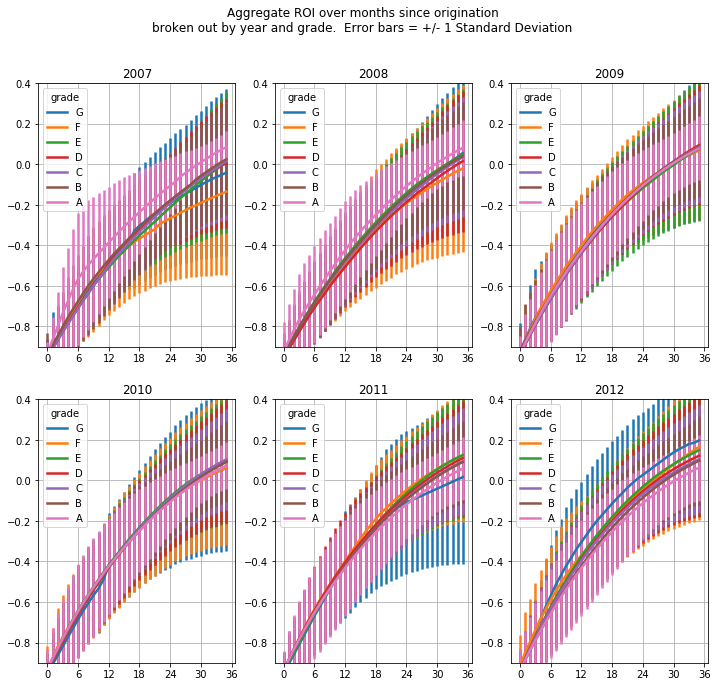

In [9]:
def make_ROI_plot(df,term):
    ROI_columns = [str(i) +"_month_ROI" for i in range(1,term+1)]
    fig, ax_tuple = plt.subplots(2,3, figsize=(12, 10.66))
    ax_list = [ax for tupl in ax_tuple for ax in tupl]
    df['issue_year'] = df.issue_d.dt.year
    x_labels = [0,6,12,18,24,30,36]
    for i,y in enumerate([2007, 2008, 2009, 2010, 2011, 2012]):
        year_df = df.loc[df.issue_year == y]
        data = year_df[ROI_columns+['grade']].groupby('grade').mean().transpose()
        errors = year_df[ROI_columns+['grade']].groupby('grade').std().transpose()
        curr_ax = ax_list[i]
        data.plot(yerr = errors, ax=curr_ax, grid=True, ylim=(-.9, .4), title=y ,linewidth=2.5, xticks=x_labels, use_index=False)
    
    plt.suptitle("Aggregate ROI over months since origination"\
                "\nbroken out by year and grade.  Error bars = +/- 1 Standard Deviation")

make_ROI_plot(pymnts_3years, 36)


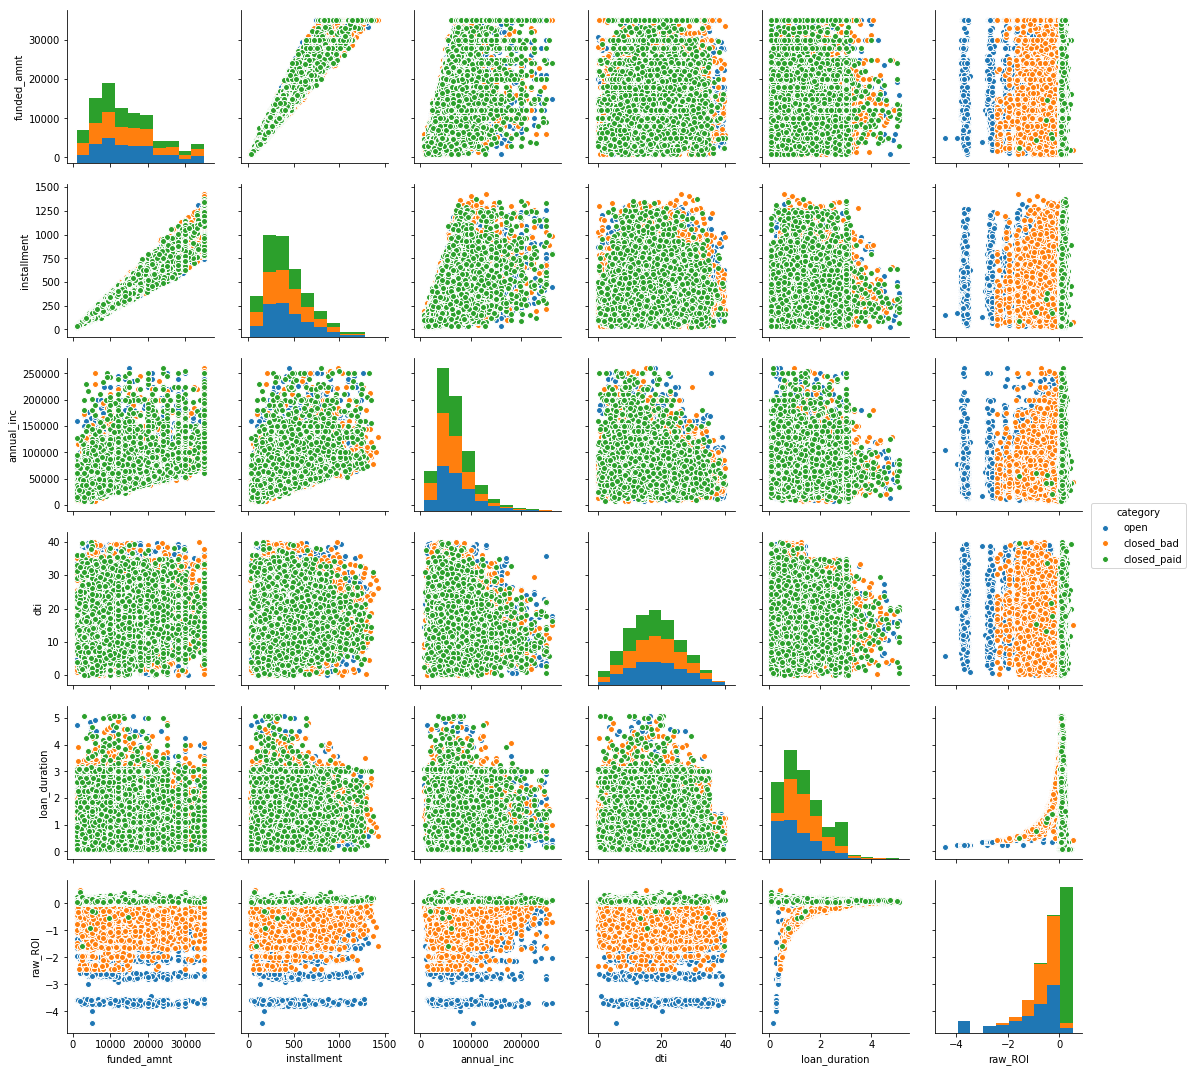

In [10]:
def outliers(df, col_name):
    return (np.abs(df[col_name] -df[col_name].mean()) / df[col_name].std()) >= 3

cont = enriched_data[[
    'funded_amnt',
    'installment',
    'annual_inc',
    'dti',
    'loan_duration',
    'loan_is_open',
    'loan_status',
    'raw_ROI'
]]
cont = cont[~outliers(cont, 'annual_inc')]
cont = cont[~outliers(cont, 'dti')]
cont = cont[~outliers(cont, 'raw_ROI')]
cont['category'] = ""
cont.loc[cont.loan_is_open, "category"] = "open"
cont.loc[
    (~cont.loan_is_open) & 
    cont.loan_status.isin(
        ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]
    ), "category"] = "closed_paid"
cont.loc[
    (~cont.loan_is_open) & 
    cont.loan_status.isin(
        ["Charged Off", "Does not meet the credit policy. Status:Charged Off"]
    ), "category"] = "closed_bad"

cont = cont.drop(['loan_status', 'loan_is_open'], axis=1)
cont_open = cont[cont.category == 'open'].sample(n=5000, replace=False)
cont_bad = cont[cont.category == 'closed_bad'].sample(n=5000, replace=False)
cont_good = cont[cont.category == 'closed_paid'].sample(n=5000, replace=False)
cont_final = pd.concat([cont_open, cont_bad, cont_good])
g = sns.pairplot(cont_final, hue="category")


In [11]:
def calc_expected_return(df):
    '''
    '''
    df['issue_d_year'] = df.issue_d.dt.year
    df = df[~df.loan_is_open]
    #df['ROI'] = (100*((df.total_pymnt - df.funded_amnt) / df.funded_amnt))/(df.loan_duration)
    mean_list = []
    std_list = []
    for term in [36, 60]:
        for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
            mean_record = {"term":term, "grade": grade}
            std_record = {"term": term, "grade": grade}
            for issue_d in [2007, 2008, 2009, 2010, 2011, 2012]:
                loans = df[(df.grade == grade) &
                           (df.term == term) &
                           (df.issue_d_year == issue_d)
                          ]
                ROI = 100*(loans[str(term)+"_month_ROI"]).mean() 
                ROI_std = 100*(loans[str(term)+"_month_ROI"]).std()
                #total_funded = loans.funded_amnt.sum()
                #total_return = loans.total_pymnt.sum()
                #ROI = (100*((total_return - total_funded) / total_funded))/(term/12)
                mean_record[str(issue_d)] = round(ROI,2)
                std_record[str(issue_d)] = round(ROI_std, 2)
                #loans.ROI.plot(normed=True)
            #plt.show()
            mean_list.append(mean_record)
            std_list.append(std_record)

    means = pd.DataFrame(mean_list)
    means = means.set_index(['grade', 'term'])
    means['AVG'] = round(means.mean(axis=1),2)
    means['+/-'] = round(means.std(axis=1),2)
    stds = pd.DataFrame(std_list)
    stds = stds.set_index(['grade', 'term'])
    stds['AVG'] = round(stds.mean(axis=1),2)
    stds['+/-'] = round(stds.std(axis=1),2)
    print('Average ROI After 3 years (5 years)')
    display(means)
    print('Std. on 3-year (5-year) ROI')
    display(stds)
                
calc_expected_return(enriched_data)


Average ROI After 3 years (5 years)


,,2007,2008,2009,2010,2011,2012,AVG,+/-
grade,term,,,,,,,,
A,36,8.58,8.16,7.91,7.39,5.90,6.35,7.38,0.96
B,36,2.56,4.04,8.14,9.21,9.11,9.76,7.14,2.79
C,36,1.65,3.57,8.61,10.43,9.47,10.44,7.36,3.46
D,36,0.53,1.58,9.51,9.33,11.03,12.18,7.36,4.57
E,36,0.99,4.74,7.66,9.97,12.59,14.95,8.48,4.69
F,36,-13.44,-2.02,6.93,6.24,12.29,16.59,4.43,9.83
G,36,-4.06,5.55,7.66,6.21,1.65,19.76,6.13,7.22
A,60,NaN,NaN,NaN,10.45,7.17,5.14,7.59,2.19
B,60,NaN,NaN,NaN,11.66,5.53,1.90,6.36,4.03


Std. on 3-year (5-year) ROI


,,2007,2008,2009,2010,2011,2012,AVG,+/-
grade,term,,,,,,,,
A,36,8.01,13.67,15.87,11.69,15.34,16.29,13.48,2.89
B,36,27.71,26.56,24.38,19.99,20.36,21.87,23.48,2.96
C,36,28.91,29.72,27.77,24.95,26.43,26.73,27.42,1.59
D,36,31.94,34.84,29.47,30.18,28.34,30.45,30.87,2.08
E,36,34.76,32.51,35.00,31.68,31.26,32.37,32.93,1.44
F,36,41.14,41.29,34.61,38.06,32.58,36.31,37.33,3.21
G,36,41.20,38.35,35.80,40.98,42.80,36.58,39.28,2.56
A,60,NaN,NaN,NaN,18.43,21.30,22.06,20.60,1.56
B,60,NaN,NaN,NaN,30.05,30.94,32.84,31.28,1.16


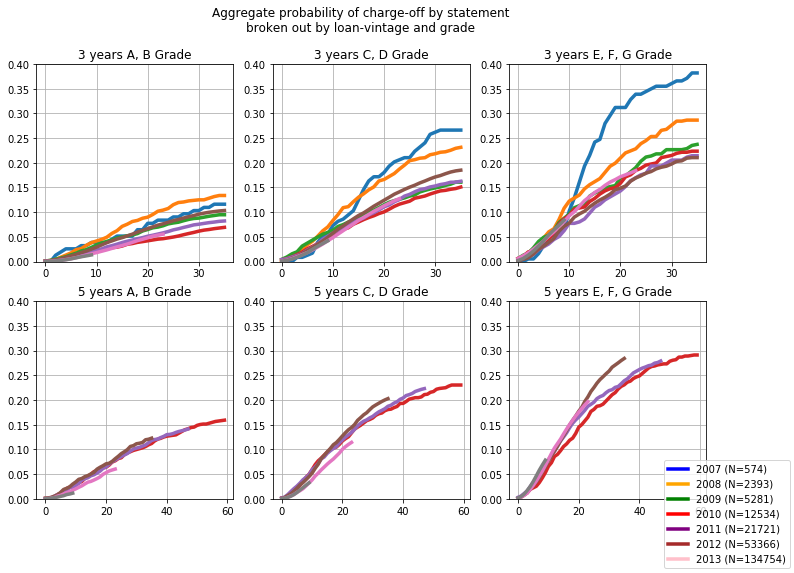

In [12]:
def calc_p_bad(vintage, period, total):
    '''
    for a given vintage calculate the percentage of loans whose last
    payment date was before loan maturity, and the loan status was not
    fully paid or current.  ASSUMPTION: these reflect non-performing
    loans
    '''
    if (total == 0):
        return np.NAN

    return (
        (
            (
                vintage.last_pymnt_d < (
                    vintage.issue_d + pd.DateOffset(months = period)
                ) 
            ) & (
                vintage.loan_status.isin([
                    "Charged Off",
                    "Default",
                    "Does not meet the credit policy. Status:Charged Off",
                ])
            )
        ).sum() / total)

def make_vintages_plot(df):
    '''
    compare p-bad rates for loans originated in different quarters from
    2007-6-1 to 2015-1-1.  We want at least a 1-year period to see if the
    loan performs.  NOTE: despite accounting for 8 of the 9 years of historical
    data, this only captures about half of the loans in the data set.
    '''
    
    def make_subplot(df, term, periods, ax_handle, title):
        
        for i in range(len(vintage_intervals)-1):
            start_date = vintage_intervals[i]
            stop_date = vintage_intervals[i+1]
            vintage = df[(df.issue_d >= start_date)
                            & (df.issue_d < stop_date)] 
            total = vintage.shape[0]

                
            p_bads = []
            for n in range(1, term + 1):
                if((stop_date + relativedelta(months=n)) > LAST_PAYMENT_DATE):
                    break
                p_bad = calc_p_bad(vintage, n, total)
                p_bads.append(p_bad)
            ax_handle.plot(p_bads, linewidth=3.5)
            ax_handle.set_title(title)
        return(ax_handle)


    vintage_intervals = [
        dt.date(2008,1,1) + relativedelta(months=x) for x in range(0,91,12) #91
    ]
    vintage_intervals.insert(0, dt.date(2007,6,1))
    vintage_intervals[-1] += relativedelta(days=1, months=1)

    fig, ((ax_1, ax_2, ax_3),(ax_4, ax_5, ax_6)) = plt.subplots(2,3, figsize=(12, 8))

    tranch_1_3year = df[df.grade.isin(['A', 'B']) & (df.term == 36)]
    tranch_2_3year = df[df.grade.isin(['C', 'D']) & (df.term == 36)]
    tranch_3_3year = df[df.grade.isin(['E', 'F', 'G']) & (df.term == 36)]
    
    tranch_1_5year = df[df.grade.isin(['A', 'B']) & (df.term == 60)]
    tranch_2_5year = df[df.grade.isin(['C', 'D']) & (df.term == 60)]
    tranch_3_5year = df[df.grade.isin(['E', 'F', 'G']) & (df.term == 60)]

    ax_1 = make_subplot(tranch_1_3year, 36,
                        vintage_intervals, ax_1,
                        "3 years A, B Grade")
    ax_1.set_ylim([0, .4])
    ax_1.grid()

    ax_2 = make_subplot(tranch_2_3year, 36,
                        vintage_intervals, ax_2,
                        "3 years C, D Grade")  
    ax_2.set_ylim([0, .4])
    ax_2.grid()
    
    ax_3 = make_subplot(tranch_3_3year, 36,
                        vintage_intervals, ax_3,
                        "3 years E, F, G Grade")  
    ax_3.set_ylim([0, .4])
    ax_3.grid()

    ax_4 = make_subplot(tranch_1_5year, 60,
                        vintage_intervals, ax_4,
                        "5 years A, B Grade")  
    ax_4.set_ylim([0, .4])
    ax_4.grid()

    ax_5 = make_subplot(tranch_2_5year, 60,
                        vintage_intervals, ax_5,
                        "5 years C, D Grade")  
    ax_5.set_ylim([0, .4])
    ax_5.grid()

    ax_6 = make_subplot(tranch_3_5year, 60,
                        vintage_intervals, ax_6,
                        "5 years E, F, G Grade")  
    ax_6.set_ylim([0, .4])
    ax_6.grid()

    line_handles = [
        mlines.Line2D([], [], color='blue', linewidth=3.5, label='2007'),
        mlines.Line2D([], [], color='orange', linewidth=3.5, label='2008'),
        mlines.Line2D([], [], color='green', linewidth=3.5, label='2009'),
        mlines.Line2D([], [], color='red', linewidth=3.5, label='2010'),
        mlines.Line2D([], [], color='purple', linewidth=3.5, label='2011'),
        mlines.Line2D([], [], color='brown', linewidth=3.5, label='2012'),
        mlines.Line2D([], [], color='pink', linewidth=3.5, label='2013'),
        mlines.Line2D([], [], color='grey', linewidth=3.5, label='2014')
    ]  
    
    value_counts = df.issue_d.dt.year.value_counts()
    years = list(value_counts.index)[2:]
    years.reverse()
    
    cnts = list(value_counts.values)[2:]
    cnts.reverse()
    labels = ["{} (N={})".format(y,c) for y,c in zip(years,cnts)]
    
    fig.suptitle("Aggregate probability of charge-off by statement" \
                 "\nbroken out by loan-vintage and grade")
    fig.legend(line_handles, labels, 'lower right')
    plt.show()

make_vintages_plot(enriched_data)


In [13]:
enriched_data.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,emp_length_imp,mths_since_last_delinq_0_24,mths_since_last_delinq_24_48,mths_since_last_delinq_48_72,mths_since_last_delinq_72_96,mths_since_last_delinq_96_inf,loan_is_open,maturity_d,earliest_cr_delta,revol_limit,avg_revol_acc_limit,avg_revol_acc_bal,percentage_funded,inst_to_income,loan_duration,raw_ROI,term_ROI,36_month_ROI,60_month_ROI,issue_d_year
0,5000.0,5000.0,4975.0,36,10.65,162.87,B,B2,10,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,2015-01-01,2016-01-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,9830,16305.854241,5435.284747,4549.333333,0.995,0.006786,3.083333,0.055853,0.057405,0.172664,NaN,2011
1,2500.0,2500.0,2500.0,60,15.27,59.83,C,C4,0,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-04-01,2013-09-01,0.0,0.0,0,0,0,0,0,0,False,2016-12-01,4627,17946.808511,5982.269504,562.333333,1.000,0.001994,1.744047,-0.342030,-0.119303,NaN,-0.596516,2011
2,2400.0,2400.0,2400.0,36,15.96,84.33,C,C5,10,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,2014-06-01,2016-01-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,3682,3001.015228,1500.507614,1478.000000,1.000,0.006883,2.500000,0.100609,0.083841,0.251522,NaN,2011
3,10000.0,10000.0,10000.0,36,13.49,339.31,C,C1,10,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,2015-01-01,2015-01-01,0.0,0.0,0,0,1,0,0,0,False,2014-12-01,5782,26657.142857,2665.714286,559.800000,1.000,0.006897,3.083333,0.072204,0.074210,0.221516,NaN,2011
4,3000.0,3000.0,3000.0,60,12.69,67.79,B,B5,1,RENT,80000.0,Source Verified,2011-12-01,Current,other,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,2016-01-01,67.79,2016-02-01,2016-01-01,0.0,0.0,0,0,1,0,0,0,True,2016-12-01,5813,51545.454545,3436.363636,1852.200000,1.000,0.000847,4.084957,0.019761,0.016145,NaN,NaN,2011


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR

#only model 3 year loans with full payment histories.  That restricts universe to issue dates before 2013-1-1
def add_features_post_split(df):
    '''
    these features considered population-level statistics and thus need to be added after train-test splits
    '''
    def zscore(s):
        return (s - s.mean()) / s.std()
    
    features = ["annual_inc", "funded_amnt", "int_rate", "dti"]
    groups = ["grade", "purpose", "addr_state"]
    for f in features:
        for g in groups:
            name = "zscore_{}_by_{}".format(f,g)
            df[name] = np.NaN
            df[name] = df.groupby([df[g]])[f].transform(zscore)
            df[name] = df[name].fillna(df[name].median())
            df[name] = df[name].fillna(0)
    
    return df


def prepare_modeling(df, scaler=None):
    standard_scale_cols = [
        'funded_amnt', 'int_rate', 'grade', 'sub_grade', 'emp_length',
        'annual_inc', 'dti', 'delinq_2yrs', 'installment', 'inq_last_6mths',
        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
        'earliest_cr_delta', 'revol_limit', 'avg_revol_acc_limit',
        'avg_revol_acc_bal', 'percentage_funded', 'inst_to_income',
        'issue_days_since_start'
    ]
    
    
    df = add_features_post_split(df)
    dummy_cols = [
        'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'addr_state'
    ]
    df = pd.get_dummies(df, columns=dummy_cols)
    df['issue_days_since_start'] = (df.issue_d - EARLIEST_ISSUE).dt.days
    
    cat_columns = ['grade', 'sub_grade']
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    df = df.drop(['loan_amnt', 'issue_d', 'loan_status', 'zip_code', 'earliest_cr_line', 'funded_amnt_inv',
                 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
                 'total_rec_int','total_rec_int','total_rec_late_fee','recoveries', 'term',
                 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
                 'last_credit_pull_d', 'loan_is_open', 'maturity_d', 'loan_duration', 'term_ROI', 'issue_d_year',
                 'raw_ROI', '60_month_ROI'], axis=1)
    
    X = df.loc[:, df.columns != '36_month_ROI']
    Y = df['36_month_ROI']
    
    if(not scaler):
        scaler = StandardScaler()
        
    X[standard_scale_cols] = scaler.fit_transform(X[standard_scale_cols])

    #df_x = df.loc[:, df.columns != 'yearly_ROI']
    #df_x[df_x.columns] = scaler.fit_transform(df_x[df_x.columns])
    #df_y = df.yearly_ROI.values*100
    #df_y = df_y.reshape(df_y.shape[0],1)
    return X, Y, scaler



    
def split(
    df,
    train_start_date=dt.date(2009,1,1),
    train_end_date=dt.date(2011,1,1),
    test_start_date=dt.date(2012,1,1),
    test_end_date=dt.date(2012,2,1)
):
    
    df_2 = df.loc[(df.issue_d >= train_start_date) &
                  (df.issue_d < train_end_date) &
                  (df.term == 36)]
    
    
    train, test = train_test_split(
        df_2, test_size=0.2, random_state=1234
    )
#     train = df.loc[(~df.loan_is_open) &
#                   (df.issue_d >= train_start_date) &
#                   (df.issue_d < train_end_date) &
#                   (df.term == 36)]
    
#     test = df.loc[(~df.loan_is_open) &
#                   (df.issue_d >= test_start_date) &
#                   (df.issue_d < test_end_date) &
#                   (df.term == 36)]
    
           
    train_x, train_y, scaler = prepare_modeling(train)
    test_x, test_y, _ = prepare_modeling(test, scaler)
    return ((train_x, train_y), (test_x, test_y))


((train_x, train_y), (test_x, test_y)) = split(enriched_data)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

(11548, 118)
(11548,)
(2888, 118)
(2888,)


In [19]:

#clf.fit(train_x, train_y)
def get_predictions(X_train, Y_train, X_test, Y_test, model):
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    X_train_values = X_train.values
    Y_train_values = Y_train.values
    X_test_values = X_test.values
    Y_test_values = Y_test.values
    
    model.fit(X_train, Y_train)
    in_sample = model.predict(X_train)
    out_sample = model.predict(X_test)
    
    print("In Sample MEAN ABS. ERROR")
    print(mean_absolute_error(Y_train_values, in_sample))
    
    print(("baseline MEAN ABS ERROR"))
    print(mean_absolute_error(Y_train_values, Y_train_values - Y_train_values.mean()))
    
    print("Out Sample MEAN ABS. ERROR")
    print(mean_absolute_error(Y_test_values, out_sample))
    
    print(("baseline MEAN ABS ERROR"))
    print(mean_absolute_error(Y_test_values, Y_test_values - Y_train_values.mean()))
    
    
    
    in_sample_pred = pd.Series(in_sample, index=train_y.index, name="in_sample_ROI")
    out_sample_pred = pd.Series(out_sample, index=test_y.index, name="out_sample_ROI")
    return(in_sample_pred, out_sample_pred)
    
#clf = linear_model.Lasso(alpha=.0001)
svr_rbf = SVR(kernel='rbf', C= 1000, gamma=.0001)
print(train_x.shape)
in_sample_pred, out_sample_pred = get_predictions(train_x, train_y, test_x, test_y, svr_rbf)
print("SIZE OF TRAIN {}".format(train_x.shape))
print("SIZE OF TEST {}".format(test_x.shape))
pred_data = enriched_data.join(in_sample_pred)
pred_data = pred_data.join(out_sample_pred)

s = pd.Series(clf.coef_, index=train_x.columns)
display(s)

(11548, 118)
(11548, 118)
(11548,)
(2888, 118)
(2888,)
In Sample MEAN ABS. ERROR
0.1339458653256133
baseline MEAN ABS ERROR
0.08834706909055412
Out Sample MEAN ABS. ERROR
0.13816087664075913
baseline MEAN ABS ERROR
0.08834706909055412
SIZE OF TRAIN (11548, 118)
SIZE OF TEST (2888, 118)


funded_amnt                      0.005349
int_rate                        -0.000000
installment                      0.000000
grade                            0.004392
sub_grade                       -0.011195
emp_length                      -0.006633
annual_inc                      -0.000308
dti                              0.000000
delinq_2yrs                      0.003810
inq_last_6mths                  -0.026638
open_acc                         0.004347
pub_rec                         -0.005555
revol_bal                       -0.010686
revol_util                       0.002586
total_acc                       -0.008177
collections_12_mths_ex_med       0.000000
acc_now_delinq                   0.000000
emp_length_imp                  -0.066845
mths_since_last_delinq_0_24      0.001400
mths_since_last_delinq_24_48     0.021596
mths_since_last_delinq_48_72     0.016703
mths_since_last_delinq_72_96    -0.000000
mths_since_last_delinq_96_inf   -0.000000
earliest_cr_delta                0

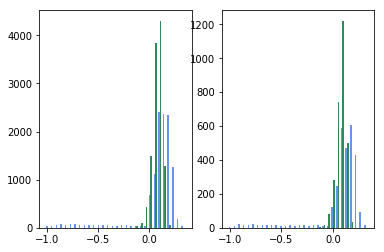

In [16]:
def make_prediction_hists(df):
    
    fig, ax_list = plt.subplots(1,2)
    for i, pred_col in enumerate(["in_sample_ROI", "out_sample_ROI"]):
        ax_handle = ax_list[i] 
        hist_data = df.loc[~df[pred_col].isnull(), ["36_month_ROI", pred_col]]
        a_heights, a_bins = np.histogram(hist_data['36_month_ROI'], bins=30)
        b_heights, b_bins = np.histogram(hist_data[pred_col], bins=a_bins)
        width = (a_bins[1] - a_bins[0])/3
        
        ax_handle.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
        ax_handle.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')
    
    return

make_prediction_hists(pred_data)

/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Late (31-120 days)                                     0
Late (16-30 days)                                      0
Issued                                                 0
In Grace Period                                        0
Fully Paid                                             0
Does not meet the credit policy. Status:Fully Paid     0
Does not meet the credit policy. Status:Charged Off    0
Default                                                0
Current                                                0
Charged Off                                            0
Name: loan_status, dtype: int64

0.0

Late (31-120 days)                                     0
Late (16-30 days)                                      0
Issued                                                 0
In Grace Period                                        0
Fully Paid                                             0
Does not meet the credit policy. Status:Fully Paid     0
Does not meet the credit policy. Status:Charged Off    0
Default                                                0
Current                                                0
Charged Off                                            0
Name: loan_status, dtype: int64

0.0

/home/peter/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Late (31-120 days)                                     0
Late (16-30 days)                                      0
Issued                                                 0
In Grace Period                                        0
Fully Paid                                             0
Does not meet the credit policy. Status:Fully Paid     0
Does not meet the credit policy. Status:Charged Off    0
Default                                                0
Current                                                0
Charged Off                                            0
Name: loan_status, dtype: int64

0.0

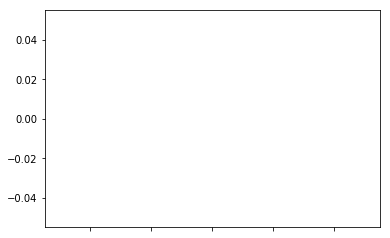

In [17]:
from sklearn.utils import shuffle

def make_oracle_loanbook(df, portfolio_size):

    oracle_data = df
    oracle_data.sort_values(by=['36_month_ROI'], ascending=False, inplace=True)
    oracle_data = oracle_data[oracle_data.loan_amnt.cumsum() <= portfolio_size]
    display(oracle_data.loan_status.value_counts())
    display(oracle_data.funded_amnt.sum())
    
    return oracle_data

def make_baseline_loanbook(df, portfolio_size):
    
    baseline_data = df
    baseline_data = shuffle(baseline_data)
    baseline_data = baseline_data[baseline_data.loan_amnt.cumsum() <= portfolio_size]
    display(baseline_data.loan_status.value_counts())
    display(baseline_data.funded_amnt.sum())
    return baseline_data

def make_model_loanbook(df, portfolio_size):
    
    model_data = df
    model_data.sort_values(by=['out_sample_ROI'], ascending=False, inplace=True)
    model_data = model_data[model_data.loan_amnt.cumsum() <= portfolio_size]
    display(model_data.loan_status.value_counts())
    display(model_data.funded_amnt.sum())
    return model_data



def make_comparison_plot(df, portfolio_size, start_date, end_date):
    ROI_columns = [str(i) +"_month_ROI" for i in range(1,37)]

    data = df.loc[
        (df.issue_d >= start_date) &
        (df.issue_d < end_date) &
        (enriched_data.term == 36)
    ]
    
    oracle_lb = make_oracle_loanbook(data, portfolio_size)
    base_lb = make_baseline_loanbook(data, portfolio_size)
    model_lb = make_model_loanbook(data, portfolio_size)
    
    year3_oracle_pymnt, _ = get_ROIs_per_month(oracle_lb)
    year3_baseline_pymnt, _ = get_ROIs_per_month(base_lb)
    year3_model_pymnt, _ = get_ROIs_per_month(model_lb)
    year3_oracle_pymnt[ROI_columns].mean().transpose().plot()
    #display(year3_oracle_pymnt.head(10))
    year3_baseline_pymnt[ROI_columns].mean().transpose().plot()
    year3_model_pymnt[ROI_columns].mean().transpose().plot()
    return
  
pred_data_train = pred_data[~pred_data.in_sample_ROI.isnull()]
pred_data_test = pred_data[~pred_data.out_sample_ROI.isnull()]
make_comparison_plot(pred_data_test, 1*10**7, dt.date(2011,1,1), dt.date(2012,1,1))

In [18]:
enriched_data.loc[(enriched_data.loan_duration > 3.1) & (enriched_data.term ==36)]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,emp_length_imp,mths_since_last_delinq_0_24,mths_since_last_delinq_24_48,mths_since_last_delinq_48_72,mths_since_last_delinq_72_96,mths_since_last_delinq_96_inf,loan_is_open,maturity_d,earliest_cr_delta,revol_limit,avg_revol_acc_limit,avg_revol_acc_bal,percentage_funded,inst_to_income,loan_duration,raw_ROI,term_ROI,36_month_ROI,60_month_ROI,issue_d_year
18,6000.0,6000.0,6000.000000,36,11.71,198.46,B,B3,1,MORTGAGE,84000.00,Verified,2011-12-01,Fully Paid,medical,890xx,UT,18.44,2.0,2003-10-01,0.0,4.0,0.0,0.0,37.73,14.0,f,0.0,0.0,7164.499852,7164.50,6000.00,1149.50,15.000000,0.00,0.0000,2015-02-01,16.98,2015-02-01,2015-07-01,0.0,0.0,0,1,0,0,0,0,False,2014-12-01,2983,0.000000,0.000000,0.000000,1.000000,0.002363,3.166667,0.061289,0.064694,0.190760,NaN,2011
50,15000.0,15000.0,15000.000000,36,9.91,483.38,B,B1,8,MORTGAGE,80000.00,Not Verified,2011-12-01,Charged Off,debt_consolidation,616xx,IL,9.12,0.0,1992-04-01,2.0,9.0,0.0,11845.0,63.70,28.0,f,0.0,0.0,16177.770000,16177.77,13556.45,2374.34,24.170000,222.81,36.3708,2014-10-01,483.38,2014-10-01,2015-03-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,7183,18594.976452,2066.108495,1316.111111,1.000000,0.006042,3.244420,0.024201,0.026173,0.095661,NaN,2011
114,10000.0,10000.0,10000.000000,36,18.25,362.78,D,D5,1,RENT,75000.00,Source Verified,2011-12-01,Charged Off,credit_card,900xx,CA,24.14,0.0,1997-03-01,0.0,9.0,0.0,22828.0,96.30,26.0,f,0.0,0.0,11730.600000,11730.60,8320.22,3145.08,36.246998,229.06,2.2906,2015-01-01,200.00,2015-01-01,2015-01-01,0.0,0.0,0,0,0,0,1,0,False,2014-12-01,5388,23705.088266,2633.898696,2536.444444,1.000000,0.004837,3.496307,0.049498,0.057687,0.306008,NaN,2011
154,7200.0,7200.0,7200.000000,36,12.42,240.59,B,B4,5,RENT,48000.00,Not Verified,2011-12-01,Fully Paid,major_purchase,602xx,IL,17.43,0.0,2006-09-01,1.0,7.0,0.0,16450.0,80.20,10.0,f,0.0,0.0,8677.156340,8677.16,7200.00,1462.16,15.000000,0.00,0.0000,2015-02-01,19.26,2015-02-01,2015-12-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,1917,20511.221945,2930.174564,2350.000000,1.000000,0.005012,3.166667,0.064788,0.068387,0.202950,NaN,2011
224,7200.0,7200.0,7200.000000,36,7.90,225.29,A,A4,3,RENT,68000.00,Source Verified,2011-12-01,Charged Off,debt_consolidation,306xx,GA,7.98,0.0,2002-01-01,0.0,5.0,0.0,8783.0,82.90,14.0,f,0.0,0.0,7730.870000,7730.87,6744.17,907.62,14.979058,64.10,11.5380,2014-11-01,225.29,2014-11-01,2015-04-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,3621,10594.692400,2118.938480,1756.600000,1.000000,0.003313,3.329295,0.022146,0.024577,0.095160,NaN,2011
707,27000.0,27000.0,27000.000000,36,9.91,870.08,B,B1,5,OWN,140000.00,Source Verified,2011-12-01,Fully Paid,debt_consolidation,021xx,MA,7.44,0.0,2003-01-01,0.0,16.0,0.0,22457.0,27.20,30.0,f,0.0,0.0,31421.508109,31421.51,27000.00,4334.51,87.000000,0.00,0.0000,2015-02-01,982.23,2015-02-01,2015-08-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,3256,82562.500000,5160.156250,1403.562500,1.000000,0.006215,3.166667,0.051714,0.054587,0.160107,NaN,2011
734,8400.0,8400.0,8400.000000,36,17.27,300.62,D,D3,10,RENT,41500.00,Source Verified,2011-12-01,Fully Paid,credit_card,061xx,CT,15.07,0.0,2007-02-01,1.0,8.0,0.0,9398.0,77.40,9.0,f,0.0,0.0,10826.091056,10826.09,8400.00,2426.09,0.000000,0.00,0.0000,2015-02-01,10.97,2015-02-01,2015-02-01,0.0,0.0,0,0,0,0,0,0,False,2014-12-01,1764,12142.118863,1517.764858,1174.750000,1.000000,0.007244,3.166667,0.091206,0.096273,0.288371,NaN,2011
913,24000.0,24000.0,24000.000000,36,12.69,805.08,B,B5,1,RENT,120000.00,Source Verified,2011-